##### Importing libraries

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")

2025-04-08 22:47:23.031313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
import glob as glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import cv2
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as Image
from PIL import ImageOps

from skimage.io import imread, imshow
from skimage.transform import resize
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50
from keras.models import Model
from keras import backend as K

##### EXTRA: GPU Memory Upgrade

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

##### EXTRA: GPU Part of Code

In [2]:
print(tf.__version__)
tf.test.is_gpu_available()

2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

##### EXTRA: Clearing GPU Memory

In [25]:
import gc
tf.keras.backend.clear_session()
gc.collect()

105

##### Paths for train and test images and segmentation masks

In [6]:
#C:\\Users\\Daniel\\OneDrive\\Desktop\\Oil Spill Detection Using Computer Vision\\

In [6]:
os.getcwd()

'/Users/sibikarthik/OIL_SPILL_DETECTION/2) SAR U-Net (Without Augmentation)'

In [8]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/train/images'
LABELS_PATH = '/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/train/labels'

IMG_PATH_TEST = '/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/images'
LABELS_PATH_TEST = '/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/labels'

##### List of all filenames in the dataset

In [11]:
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

##### Metadata of dataset

In [14]:
print("Number of train images: ", len(IMG_PATH))
print("Number of train masks: ", len(LABELS_PATH))
print("Number of test images: ", len(IMG_PATH_TEST))
print("Number of test masks: ", len(LABELS_PATH_TEST))

Number of train images:  60
Number of train masks:  60
Number of test images:  59
Number of test masks:  59


##### Random printing of image and masks

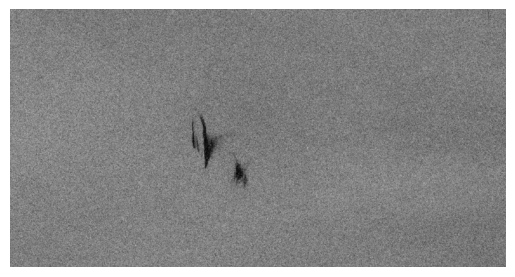

Randomly selected image: img_0037.jpg


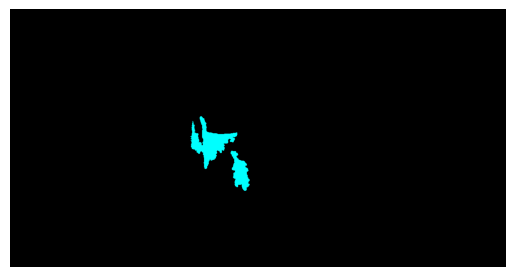

Randomly selected mask: img_0037.png


In [17]:
# Choose a random image and mask filename from the list
x = random.randint(0,1001)
random_image_name = IMG_IDS[x]
random_mask_name = LABELS_IDS[x]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

mask = mpimg.imread(mask_path)
plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

##### Conversion from RGB segmentation mask to multi-channel binary mask 

In [20]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

##### Skeletal directories initialization

In [23]:
train_images = []
train_masks = []

test_images = []
test_masks = []

#### Training data

In [26]:
from tqdm import tqdm

for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS), total=len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    # Read and validate the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        continue

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    if mask is None:
        print(f"Error: Could not read mask at {mask_path}")
        continue

    # Resize the image and mask
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255.0  # Normalization

    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask, COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

print("Data loading complete. Images:", train_images.shape, "Masks:", train_masks.shape)

  0%|▏                                         | 5/1003 [00:00<00:24, 41.55it/s]

Error: Could not read image at /Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/train/images/.DS_Store


100%|███████████████████████████████████████| 1003/1003 [00:23<00:00, 42.40it/s]


Data loading complete. Images: (1002, 256, 256, 3) Masks: (1002, 256, 256, 1)


In [27]:
train_masks.shape

(1002, 256, 256, 1)

##### Plotting train images and masks

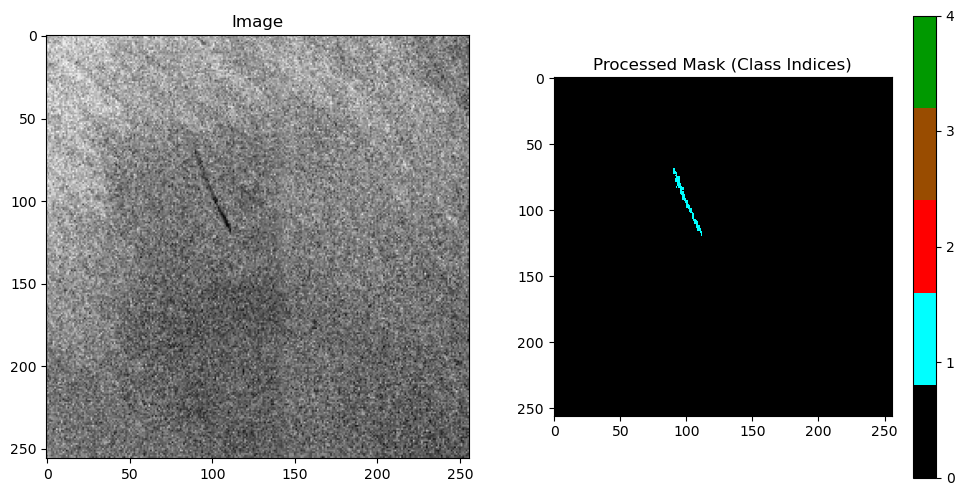

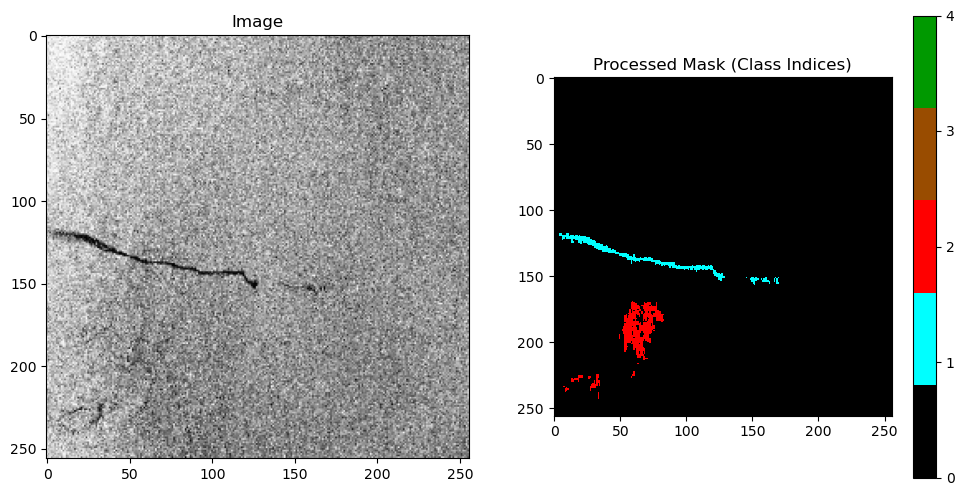

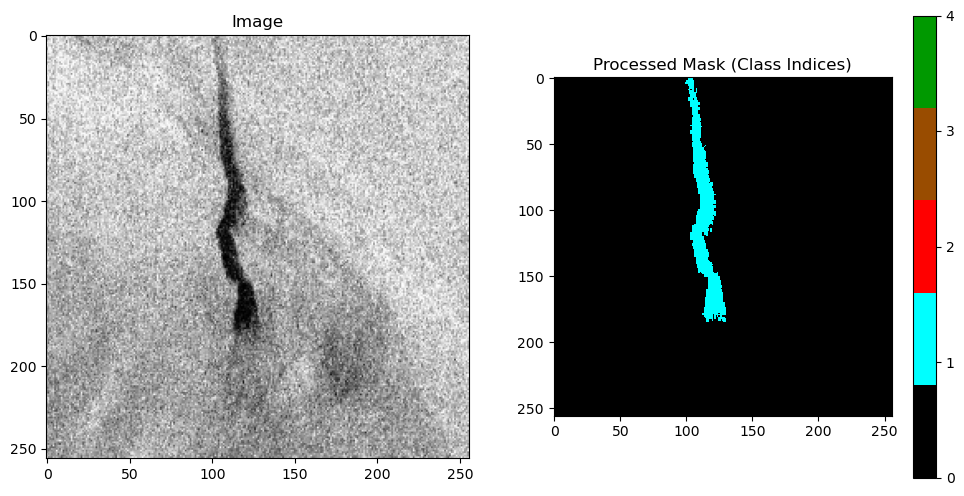

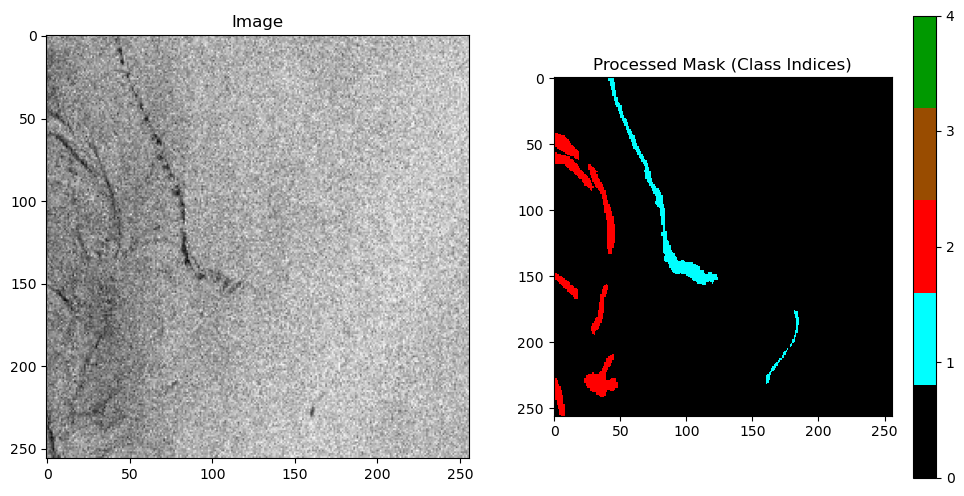

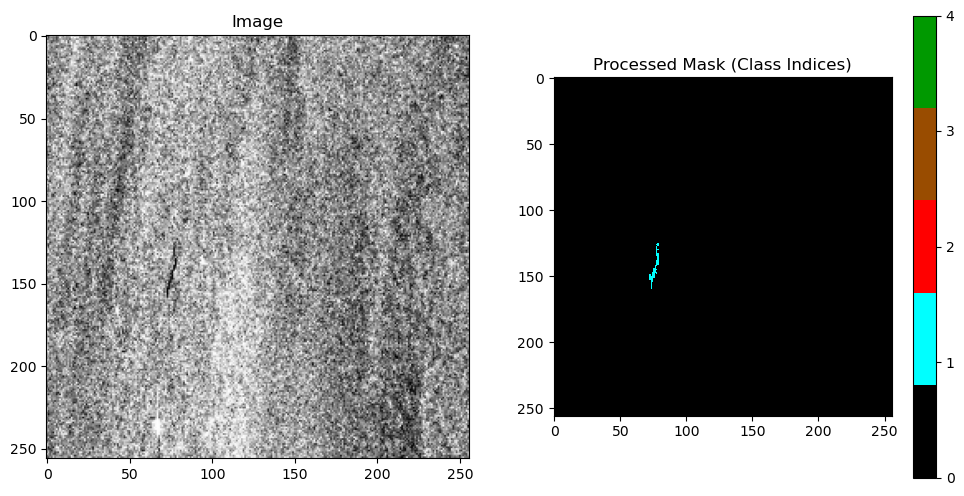

In [29]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[i])
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

#### Testing data

In [31]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST), total=len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    # Skip if files are missing
    if not os.path.isfile(image_path) or not os.path.isfile(mask_path):
        print(f"Skipping missing file: {image_path} or {mask_path}")
        continue

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # Skip if files could not be read
    if image is None or mask is None:
        print(f"Failed to load image or mask: {image_path} or {mask_path}")
        continue

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255.0  # Normalize

    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask, COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

test_images = np.array(test_images)
test_masks = np.array(test_masks)

  5%|█▉                                         | 5/111 [00:00<00:02, 42.31it/s]

Failed to load image or mask: /Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/images/.DS_Store or /Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/labels/.DS_Store


100%|█████████████████████████████████████████| 111/111 [00:02<00:00, 43.98it/s]


In [32]:
test_masks.shape

(110, 256, 256, 1)

#### to_categorical (to convert masks to one-hot encoded 5 classes)

In [34]:
from keras.utils import to_categorical
train_masks = to_categorical(train_masks, num_classes = 5)

In [35]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [36]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [37]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


##### Per-class pixel count for training masks

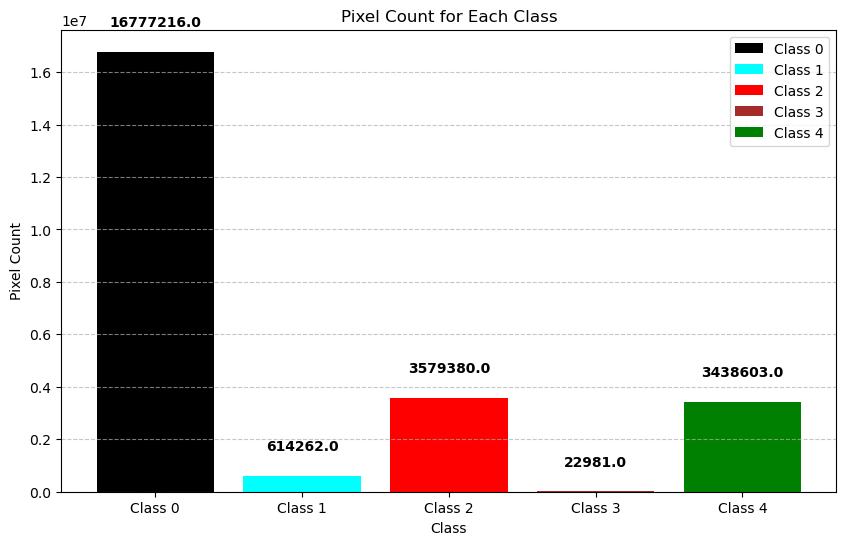

In [39]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

### U-Net Model

In [41]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [42]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

##### Model instantiation

In [54]:
unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

2025-04-08 15:00:35.103877: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-08 15:00:35.104343: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-08 15:00:35.104928: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-08 15:00:35.105830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 15:00:35.106604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

##### Model plotting

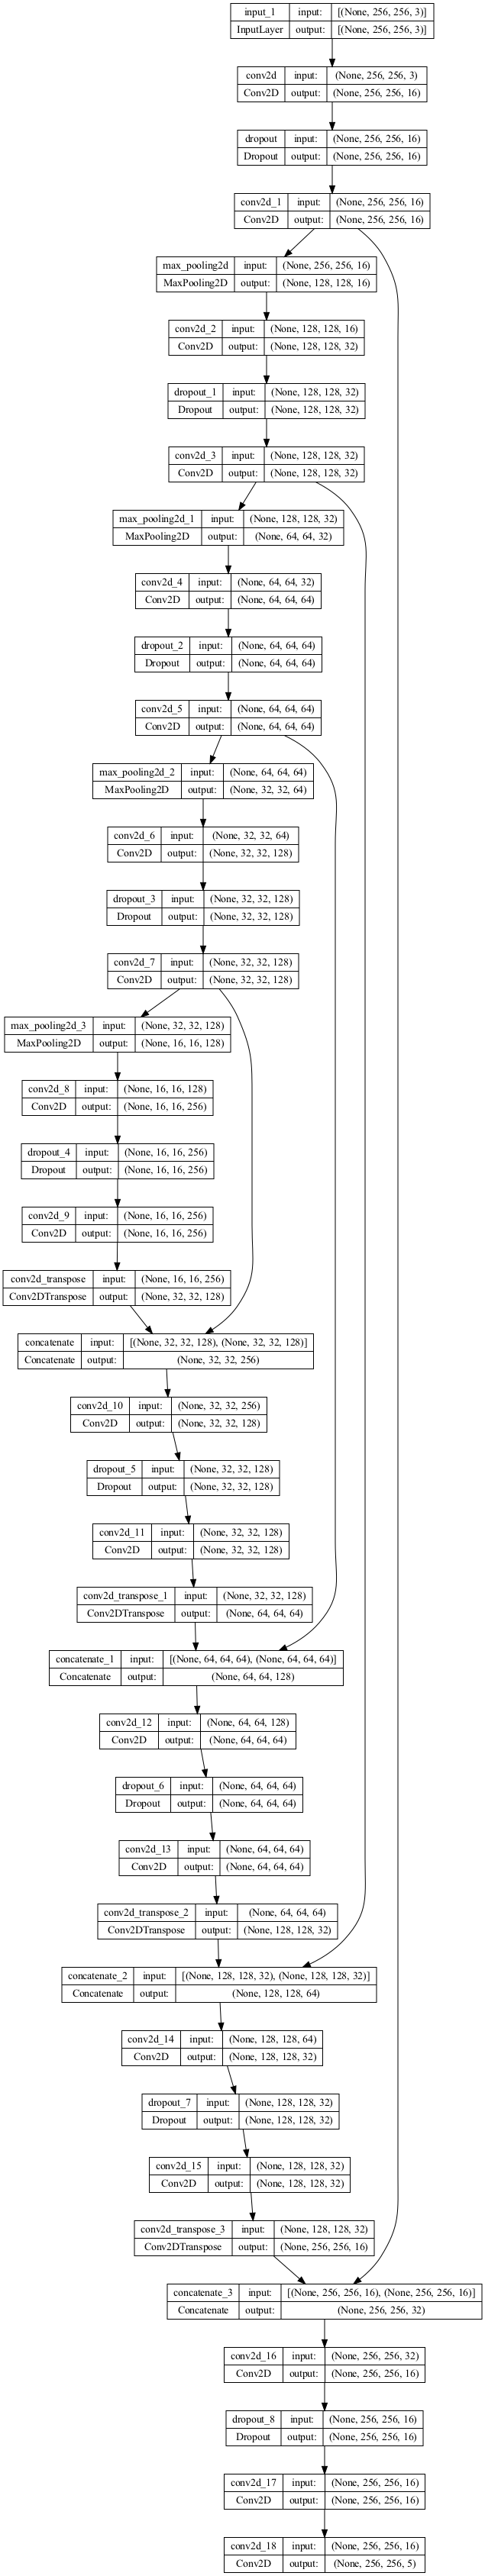

In [57]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

#unet_model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
tf.keras.utils.plot_model(unet_model, show_shapes=True, dpi=72)

##### Model Compiling

In [64]:
tf.keras.backend.clear_session()

unet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics='accuracy')

#### Training U-Net Model

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint
checkpoint_path = "best_sar_model_without_aug.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode="min")

# Training model with checkpoint
unet = unet_model.fit(train_images,
    train_masks,
    epochs=25,
    batch_size=8,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
113/113 [==============================] - 19s 108ms/step - loss: 0.5887 - accuracy: 0.8600 - val_loss: 0.4475 - val_accuracy: 0.8967
Epoch 2/25
113/113 [==============================] - 10s 85ms/step - loss: 0.4307 - accuracy: 0.8866 - val_loss: 0.2810 - val_accuracy: 0.9161
Epoch 3/25
113/113 [==============================] - 9s 84ms/step - loss: 0.3571 - accuracy: 0.8888 - val_loss: 0.2733 - val_accuracy: 0.9153
Epoch 4/25
113/113 [==============================] - 10s 86ms/step - loss: 0.3172 - accuracy: 0.8900 - val_loss: 0.2457 - val_accuracy: 0.9097
Epoch 5/25
113/113 [==============================] - 9s 82ms/step - loss: 0.2991 - accuracy: 0.8997 - val_loss: 0.3123 - val_accuracy: 0.8706
Epoch 6/25
113/113 [==============================] - 10s 85ms/step - loss: 0.2851 - accuracy: 0.9028 - val_loss: 0.2336 - val_accuracy: 0.9225
Epoch 7/25
113/113 [==============================] - 9s 82ms/step - loss: 0.2897 - accuracy: 0.9029 - val_loss: 0.2875 - val_accuracy: 0

#### Saving

##### Model

In [27]:
unet_model.save("sar_unet_without_augmentation.keras")
unet_model.save("sar_unet_without_augmentation.h5")

##### Training History

In [28]:
import pickle
with open("history_sar_unet_without_augmentation.pkl", "wb") as f:
    pickle.dump(unet.history, f)
    #pickle.dump(unet, f)
print("Model and history saved!")

Model and history saved!


#### Loading

##### Model

In [45]:
from tensorflow.keras.models import load_model
unet_model = load_model("/Users/sibikarthik/OIL_SPILL_DETECTION/2) SAR U-Net (Without Augmentation)/sar_without_augmentation.keras")

##### Training History

In [47]:
import pickle
with open("/Users/sibikarthik/OIL_SPILL_DETECTION/2) SAR U-Net (Without Augmentation)/history_sar_without_augmentation.pkl", "rb") as f:
    unet = pickle.load(f)
print("Model and history restored!")

Model and history restored!


#### Model Visualization

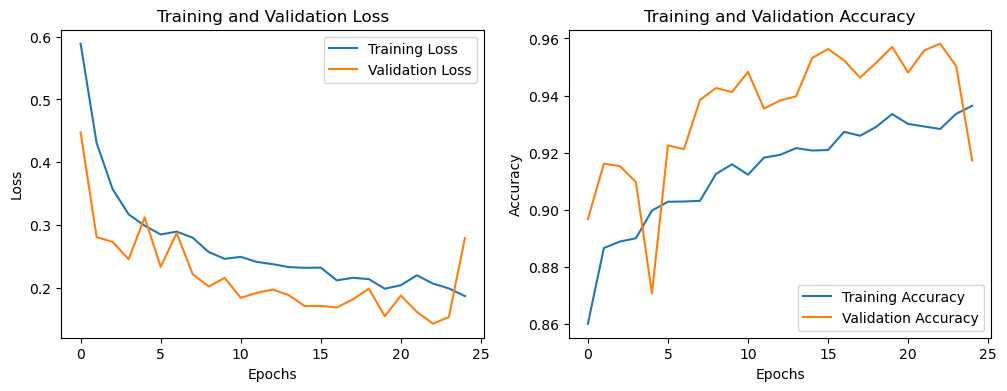

In [50]:
# Access the training history
unet_loss = unet['loss']
unet_val_loss = unet['val_loss']
unet_accuracy = unet['accuracy']
unet_val_accuracy = unet['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Prediction using Model

1/1 [==============================] - 0s 382ms/step


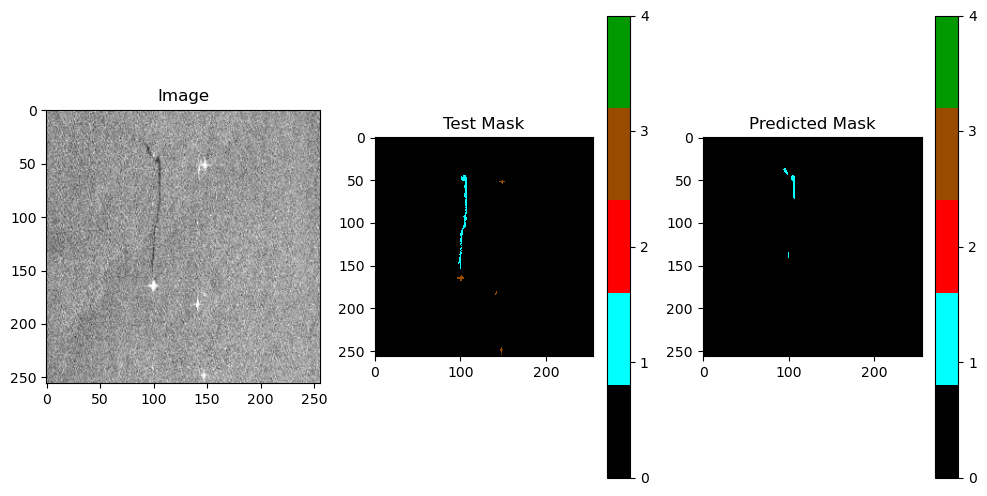

1/1 [==============================] - 0s 79ms/step


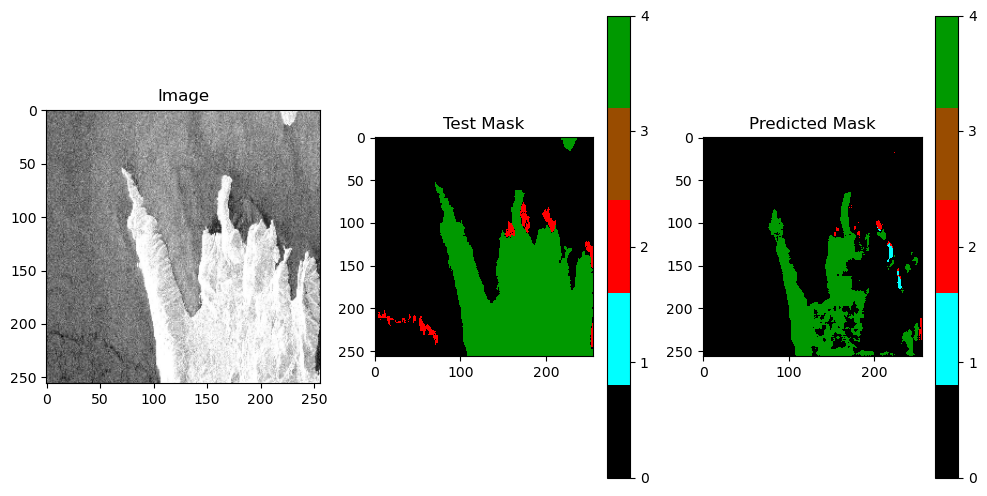

1/1 [==============================] - 0s 79ms/step


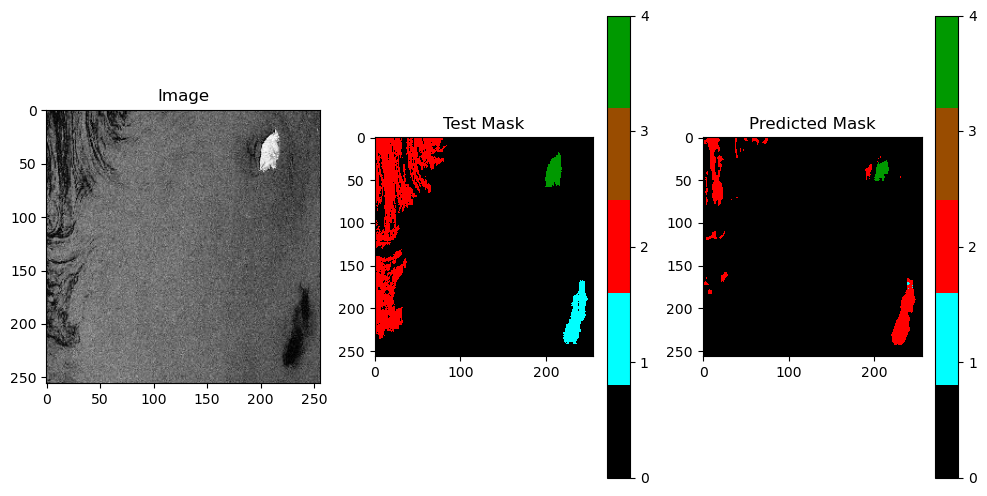

1/1 [==============================] - 0s 73ms/step


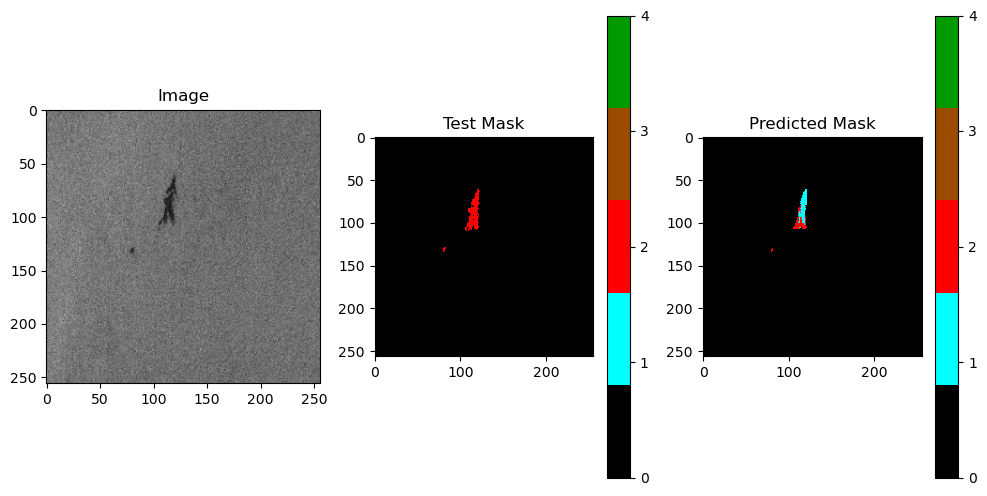

1/1 [==============================] - 0s 70ms/step


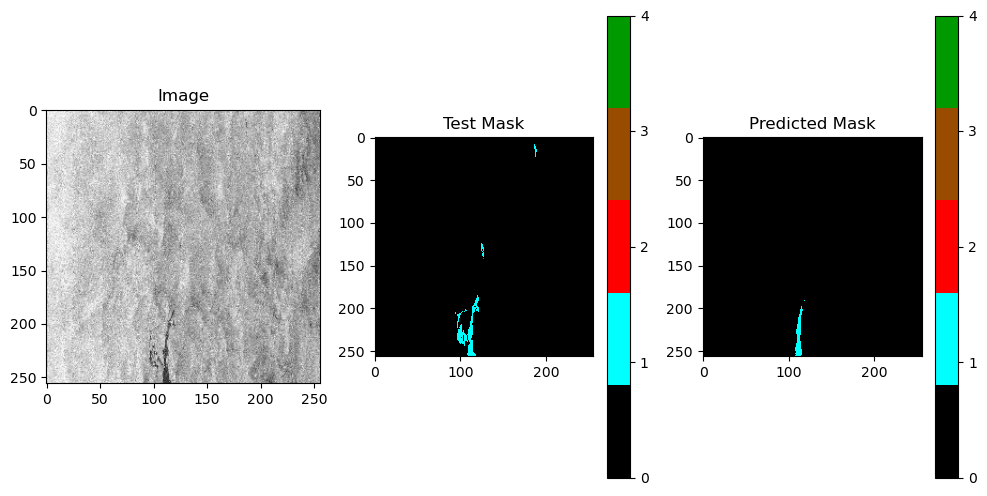

In [52]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))
    
    # Test Image 
    plt.subplot(1, 3, 1)
    test_image = test_images[i]
    plt.imshow(test_image)
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    prediction = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()

##### Confusion matrix and performance metrics

In [67]:
prediction = unet_model.predict(test_images)

print(test_masks.shape)
print(prediction.shape)

4/4 [==============================] - 6s 1s/step
(110, 256, 256, 1)
(110, 256, 256, 5)


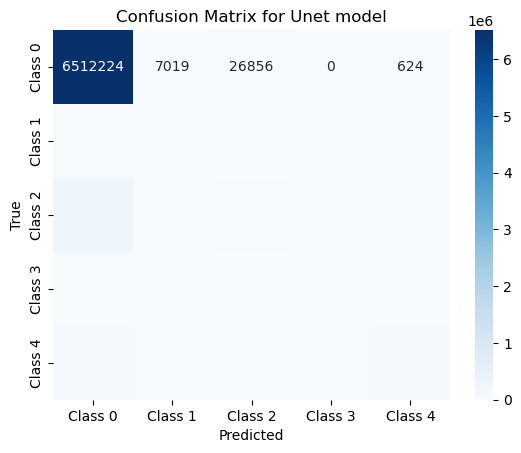

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9183
Recall: 0.9311
F1 Score: 0.9151


In [68]:
# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction, axis=-1).flatten()
#unet_predicted_labels = (prediction > 0.5).astype(np.uint8).flatten()
#unet_true_labels = test_masks.flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

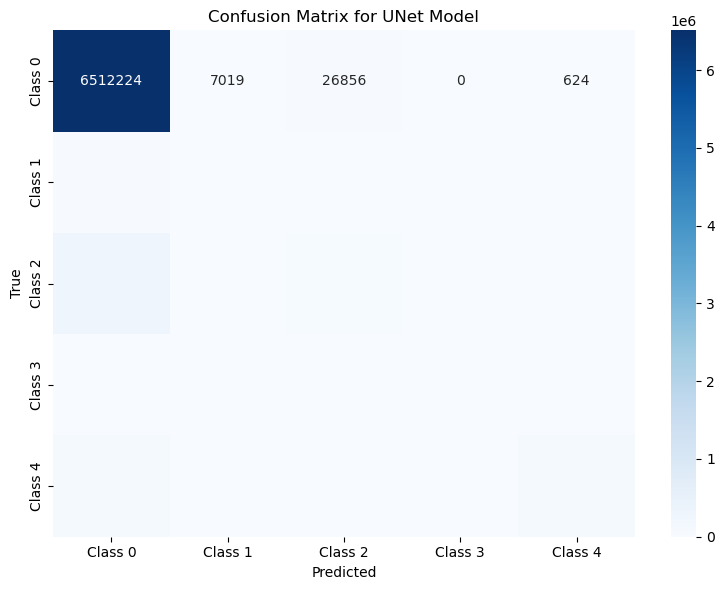


Classification Report:



/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96   6546723
     Class 1       0.62      0.27      0.37     72080
     Class 2       0.60      0.18      0.28    360390
     Class 3       0.00      0.00      0.00       672
     Class 4       0.99      0.50      0.67    229095

    accuracy                           0.93   7208960
   macro avg       0.63      0.39      0.46   7208960
weighted avg       0.92      0.93      0.92   7208960


Class 0:
  True Positives (TP): 6512224
  False Positives (FP): 440309
  False Negatives (FN): 34499
  True Negatives (TN): 221928

Class 1:
  True Positives (TP): 19236
  False Positives (FP): 11957
  False Negatives (FN): 52844
  True Negatives (TN): 7124923

Class 2:
  True Positives (TP): 65812
  False Positives (FP): 44075
  False Negatives (FN): 294578
  True Negatives (TN): 6804495

Class 3:
  True Positives (TP): 0
  False Positives (FP): 0
  False Negatives (FN): 672
  True Negatives (TN): 720828

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true and predicted labels
true_labels = test_masks.flatten()
pred_labels = np.argmax(prediction, axis=-1).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Show the confusion matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(cm.shape[0])],
            yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for UNet Model')
plt.tight_layout()
plt.show()

# Classification report (precision, recall, f1-score per class)
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=[f"Class {i}" for i in range(cm.shape[0])]))

# Number of classes
num_classes = cm.shape[0]

for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    print(f"\nClass {i}:")
    print(f"  True Positives (TP): {TP}")
    print(f"  False Positives (FP): {FP}")
    print(f"  False Negatives (FN): {FN}")
    print(f"  True Negatives (TN): {TN}")

##### Single Image Prediction

1/1 [==============================] - 0s 120ms/step


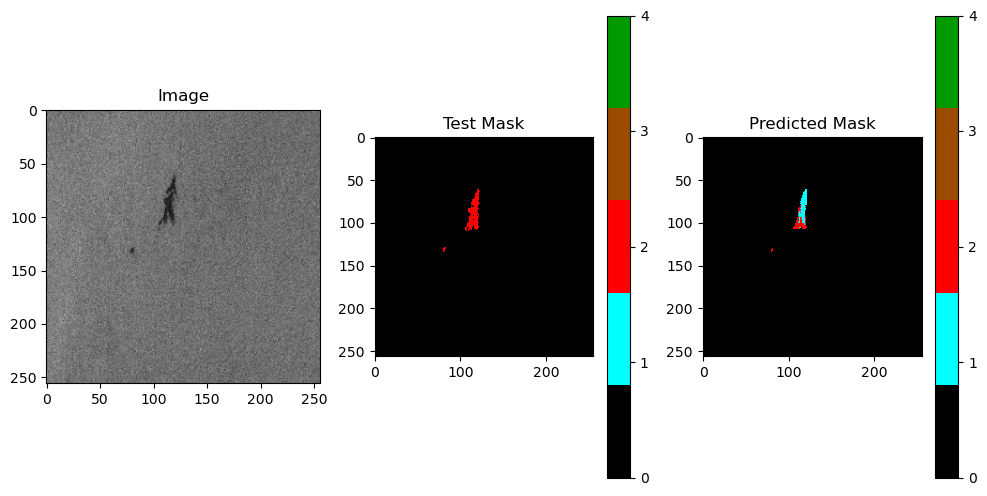

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
test_image = test_images[3]
plt.imshow(test_image)
plt.title("Image")
    
# Test Mask
plt.subplot(1, 3, 2)
test_mask = test_masks[3]
plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
plt.colorbar(ticks=range(len(COLOR_MAP)))
plt.title("Test Mask")
    
# Predicted Mask
plt.subplot(1, 3, 3)
prediction = unet_model.predict(np.expand_dims(test_image, axis=0))
predicted_mask_unet = np.argmax(prediction, axis=3)[0, :, :]
plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
plt.colorbar(ticks=range(len(COLOR_MAP)))
plt.title("Predicted Mask")
    
plt.show()

#####

### Intensity Calculation

##### Importing libraries

In [79]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.cluster import DBSCAN

##### Load and preprocess image

In [82]:
image = cv2.imread("/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/images/img_0105.jpg")
original_h, original_w = image.shape[:2]
new_h, new_w = 256, 256

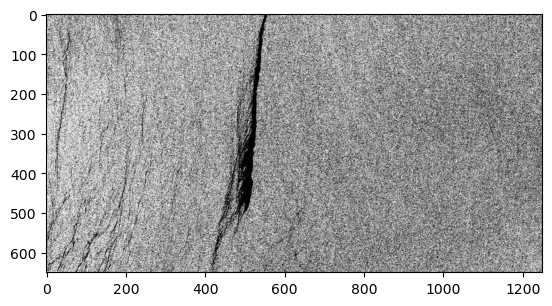

In [84]:
plt.imshow(image, cmap='gray')

##### Resize while maintaining aspect ratio

In [87]:
scale = min(new_w / original_w, new_h / original_h)
resized_w, resized_h = int(original_w * scale), int(original_h * scale)
resized_image = cv2.resize(image, (resized_w, resized_h))

# Pad to 256x256
padded_image = np.ones((new_h, new_w, 3), dtype=np.uint8) * 255
pad_x = (new_w - resized_w) // 2
pad_y = (new_h - resized_h) // 2
padded_image[pad_y:pad_y + resized_h, pad_x:pad_x + resized_w] = resized_image

##### Normalize and prepare for model

In [90]:
image = padded_image / 255.0
image_tensor = np.expand_dims(image, axis=0)

##### Predict mask

In [93]:
mask = unet_model.predict(image_tensor)[0]  # Output shape (256, 256, 5)

1/1 [==============================] - 0s 175ms/step


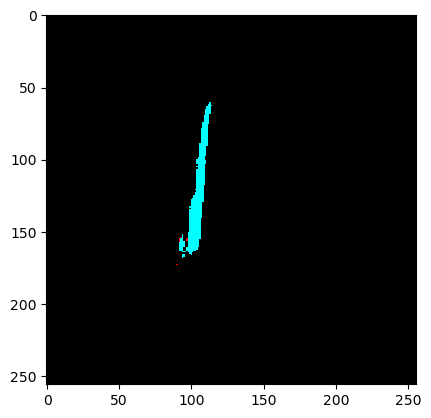

In [103]:
#prediction = unet_model.predict(np.expand_dims(test_image, axis=0))
to_print = np.argmax(mask, axis=2)
plt.imshow(to_print.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')

##### Saving mask

In [106]:
mask_output = (mask[:, :, 1] * 255).astype(np.uint8)  # Assuming oil spill channel is index 1
cv2.imwrite("mask_output_2.png", mask_output)

True

##### Calculate severity and intensity

In [109]:
intensity_map = mask[:, :, 1]
severity = np.sum(intensity_map) / (256 * 256)

# Analyzing spills
mask_bin = (intensity_map > 0.5).astype(np.uint8)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
spills = []
ref_point = (128, 128)
spill_coords = []

In [111]:
def calculate_model_accuracy(mask, ground_truth):
    correct_pixels = np.sum(mask.argmax(axis=-1) == ground_truth)
    total_pixels = mask.shape[0] * mask.shape[1]
    return correct_pixels / total_pixels

In [113]:
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    M = cv2.moments(cnt)
    cx, cy = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) if M['m00'] != 0 else (0, 0)
    dist = distance.euclidean((cx, cy), ref_point)
    weight = area * np.mean(intensity_map)
    spills.append({'area': area, 'perimeter': perimeter, 'centroid': (cx, cy), 'distance': dist, 'weight': weight})
    spill_coords.append((cx, cy))

##### Prioritizing spills

In [116]:
spills = sorted(spills, key=lambda x: x['weight'], reverse=True)

##### Identify high-impact zone using clustering

In [119]:
spill_coords = np.array(spill_coords)
if len(spill_coords) > 1:
    clustering = DBSCAN(eps=20, min_samples=2).fit(spill_coords)
    clusters = clustering.labels_
else:
    clusters = [0] * len(spill_coords)

##### Find the largest cluster

In [122]:
cluster_weights = {label: 0 for label in set(clusters) if label != -1}
for i, spill in enumerate(spills):
    if clusters[i] != -1:
        cluster_weights[clusters[i]] += spill['weight']

high_impact_zone = max(cluster_weights, key=cluster_weights.get) if cluster_weights else None

##### Visualization

/var/folders/b1/nb_549714h9c28550y1_1n280000gq/T/ipykernel_23709/1191690034.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(set(clusters)))(range(len(set(clusters))))


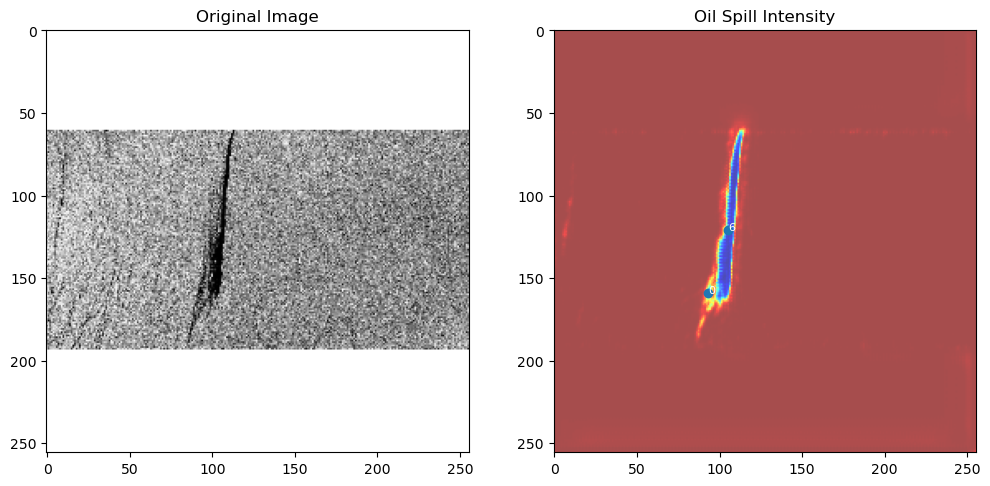

In [125]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
mask_overlay = (intensity_map * 255).astype(np.uint8)
mask_overlay = cv2.applyColorMap(mask_overlay, cv2.COLORMAP_JET)
plt.imshow(mask_overlay, alpha=0.7)
plt.title("Oil Spill Intensity")

colors = plt.cm.get_cmap('tab10', len(set(clusters)))(range(len(set(clusters))))

for i, spill in enumerate(spills):
    cx, cy = spill['centroid']
    plt.scatter(cx, cy, color=colors[clusters[i] % len(colors)], label=f"Cluster {clusters[i]}" if clusters[i] != -1 else "Noise")
    plt.text(cx, cy, f"{int(spill['weight'])}", color='white', fontsize=8)

plt.show()

##### Printing results

In [128]:
print("Overall Severity:", severity)
for i, spill in enumerate(spills[:3]):
    print(f"Top Spill {i+1}: Area={spill['area']}, Circumference={spill['perimeter']}, Distance={spill['distance']}, Weight={spill['weight']}")

if high_impact_zone is not None:
    print(f"High-impact zone identified: Cluster {high_impact_zone}")
else:
    print("No significant high-impact zone identified.")

Overall Severity: 0.012691092677414417
Top Spill 1: Area=508.0, Circumference=232.36753106117249, Distance=24.041630560342615, Weight=6.447075080126524
Top Spill 2: Area=9.0, Circumference=15.656854152679443, Distance=46.75467891024384, Weight=0.11421983409672976
No significant high-impact zone identified.


##### Output relevant metrics

In [137]:
metrics = {
    "severity": severity,
    "num_spills": len(spills),
    "total_spill_area": sum(spill['area'] for spill in spills),
    "mean_spill_intensity": np.mean([spill['weight'] for spill in spills]) if spills else 0,
    "mask_file": "mask_output.png",
    "high_impact_zone": high_impact_zone
}

for key, value in metrics.items():
    print(f"{key}: {value}")

severity: 0.012691092677414417
num_spills: 2
total_spill_area: 517.0
mean_spill_intensity: 3.280647457111627
mask_file: mask_output.png
high_impact_zone: None
